In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]
M, N = size(X)

(2, 103)

In [3]:
# GAN settings
zdim = 1 # code dimension
xdim = M # dimension of data
hiddendim = 32  

# setup the GAN model object
gsize = [zdim; hiddendim; hiddendim; xdim] # generator layout
dsize = [xdim; hiddendim*2; hiddendim*2; 1] # discriminator layout
lambda = 0.5 # anomaly score parameter in [0, 1]
# 1 - ignores the discriminator score
# 0- ignores the reconstruction error score
threshold = 0 # classification threshold, is recomputed (getthreshold or when using fit!)
contamination = size(Y[Y.==1],1)/size(Y, 1) # contamination ratio
batchsize = 30 # batchsize
iterations = 15000 # no of iterations
cbit = 5000 # when should output be printed
nepochs = Int(ceil(batchsize*iterations/size(nX,2))) # if this is supplied, do epoch training
verbfit = true # if output should be produced
pz = randn # code distribution (rand should also work)
activation = Flux.leakyrelu # should work better than relu
layer = Flux.Dense
rdelta = 1e-5 # stop training after this reconstruction error is achieved
# this parameter is basically useless in the case of GANs
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = GANmodel(gsize, dsize; lambda=lambda, threshold=threshold, 
    contamination=contamination, batchsize=batchsize, iterations=iterations, 
    cbit=cbit, nepochs = nepochs, verbfit=verbfit, 
    pz = pz, activation = activation, rdelta = rdelta, Beta = Beta, 
    layer = layer, tracked = tracked, eta = eta)

AnomalyDetection.GANmodel(AnomalyDetection.GAN(Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu), Dense(32, 2)), Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu), Dense(32, 2)), Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu), Dense(64, 1, NNlib.σ)), Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu), Dense(64, 1, NNlib.σ)), randn), 0.5, 0, 0.1262135922330097, 30, 15000, 5000, 5000, true, 1.0f-5, 1.0f0, MVHistory{ValueHistories.History}, 0.001)

In [4]:
# fit the model
Z = AnomalyDetection.getcode(model, size(nX,2))
AnomalyDetection.evalloss(model, nX, Z)
AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX, Z)

discriminator loss: 0.6653166
generator loss: 0.6874858
reconstruction error: 0.5272012



Progress:   0%|                                         |  ETA: 8:32:03
  discriminator loss:    0.6573374
  generator loss:        0.68861467
Progress:   1%|                                         |  ETA: 0:05:13
  discriminator loss:    0.652521
  generator loss:        1.0276186
Progress:   1%|█                                        |  ETA: 0:03:34
  discriminator loss:    0.61943924
  generator loss:        0.7469194
Progress:   2%|█                                        |  ETA: 0:02:58
  discriminator loss:    0.67282414
  generator loss:        0.6756176
Progress:   2%|█                                        |  ETA: 0:02:35
  discriminator loss:    0.69670963
  generator loss:        0.6700135
Progress:   3%|█                                        |  ETA: 0:02:17
  discriminator loss:    0.7091767
  generator loss:        0.6756529
Progress:   3%|█                                        |  ETA: 0:02:05
  discriminator loss:    0.6408254
  generator loss:        0.8556623
Pro

Progress:  31%|█████████████                            |  ETA: 0:00:37
  discriminator loss:    0.7014556
  generator loss:        0.67258096
Progress:  31%|█████████████                            |  ETA: 0:00:37
  discriminator loss:    0.6780788
  generator loss:        0.6742086
Progress:  32%|█████████████                            |  ETA: 0:00:36
  discriminator loss:    0.6952662
  generator loss:        0.75726384
Progress:  33%|█████████████                            |  ETA: 0:00:36
  discriminator loss:    0.68516994
  generator loss:        0.6940287
Progress:  33%|██████████████                           |  ETA: 0:00:35
  discriminator loss:    0.6830008
  generator loss:        0.6944002
Progress:  34%|██████████████                           |  ETA: 0:00:35
  discriminator loss:    0.69695765
  generator loss:        0.685222
Progress:  35%|██████████████                           |  ETA: 0:00:34
  discriminator loss:    0.6721112
  generator loss:        0.8170532
Pro

Progress:  63%|██████████████████████████               |  ETA: 0:00:18
  discriminator loss:    0.68119216
  generator loss:        0.69511116
Progress:  64%|██████████████████████████               |  ETA: 0:00:17
  discriminator loss:    0.69113797
  generator loss:        0.7047327
Progress:  65%|███████████████████████████              |  ETA: 0:00:17
  discriminator loss:    0.68407655
  generator loss:        0.7058058
Progress:  65%|███████████████████████████              |  ETA: 0:00:17
  discriminator loss:    0.72279817
  generator loss:        0.6249959
Progress:  66%|███████████████████████████              |  ETA: 0:00:16
  discriminator loss:    0.64851046
  generator loss:        0.8468455
Progress:  67%|███████████████████████████              |  ETA: 0:00:16
  discriminator loss:    0.67965245
  generator loss:        0.7619136
Progress:  68%|████████████████████████████             |  ETA: 0:00:15
  discriminator loss:    0.7157317
  generator loss:        0.6954272

Progress:  96%|███████████████████████████████████████  |  ETA: 0:00:02
  discriminator loss:    0.68491364
  generator loss:        0.7033592
Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:01
  discriminator loss:    0.6918042
  generator loss:        0.7038649
Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01
  discriminator loss:    0.6801282
  generator loss:        0.6809711
Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01
  discriminator loss:    0.6899924
  generator loss:        0.6985686
Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00
  discriminator loss:    0.6903353
  generator loss:        0.6950944
nstruction error:  0.15108703

discriminator loss: 0.6846069
generator loss: 0.7071429
reconstruction error: 0.16846344



Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00
  discriminator loss:    0.68432784
  generator loss:        0.7079008
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
  discriminator loss:    0.68436885
  generator loss:        0.69877833
  reconstruction error:  0.16077977


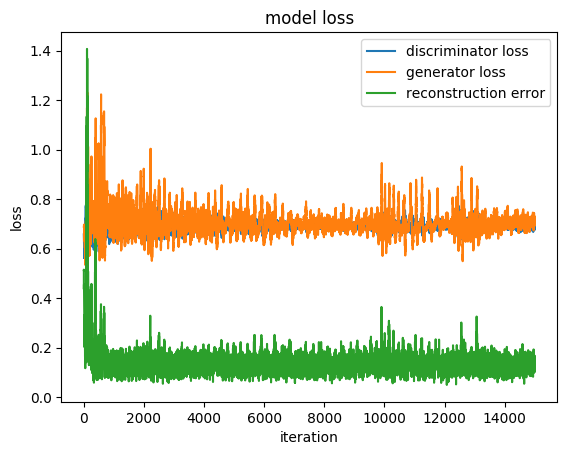

In [5]:
# plot model loss
plot(model)
show()

In [6]:
# generate new data
xgen = AnomalyDetection.generate(model, N)

2×103 Array{Float32,2}:
 0.794645  -0.00691357  -0.000546634  …  0.591073  0.528745  -0.00998831
 0.804626   1.1709       1.0665          0.605211  0.539403   1.201     

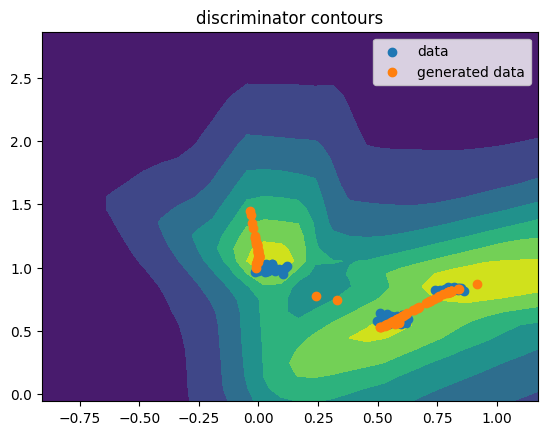

In [7]:
# plot them
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)


x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.discriminate(model, AnomalyDetection.Float.([x[j], y[i]]))[1]
    end
end

figure()
contourf(x, y, zz)
scatter(nX[1,:], nX[2,:], label = "data")
scatter(xgen[1,:], xgen[2,:], label = "generated data")
title("discriminator contours")
xlim(xl)
ylim(yl)
legend()
show()

Classification is based on anomaly score computed as a weighted average of reconstruction error and discriminator score
\begin{equation}
A(x) = (1-\lambda)D(x)+\lambda||x-G(z)||_{2, z \sim p(z)}
\end{equation}

In [8]:
# predict labels
AnomalyDetection.setthreshold!(model, X)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1

In [9]:
# get all the labels
tryhat, tstyhat, _, _ = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 86
  fp = 4
  fn = 0
precision: 0.7647058823529411
f1score: 0.8666666666666667
recall: 1.0
false positive rate: 0.044444444444444446
equal error rate: 0.022222222222222223

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 84
  fp = 6
  fn = 1
precision: 0.6666666666666666
f1score: 0.7741935483870968
recall: 0.9230769230769231
false positive rate: 0.06666666666666667
equal error rate: 0.07179487179487179


In [10]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

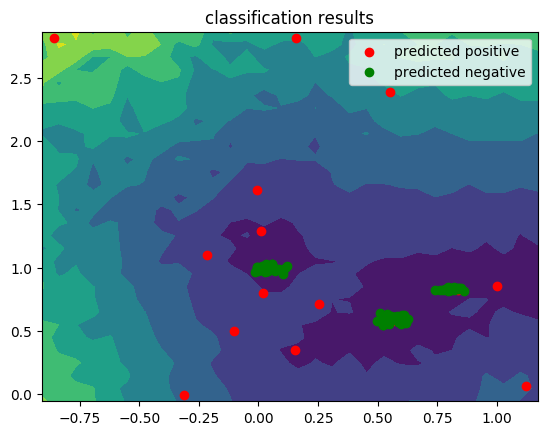

In [11]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

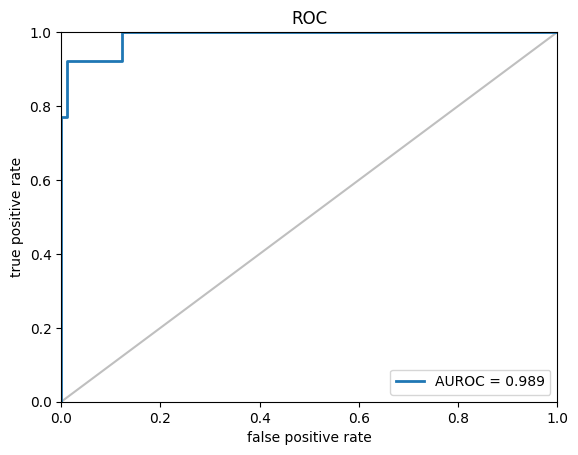

In [12]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()

In [13]:
# plot EER for different settings of lambda
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate
n = 21
lvec = linspace(0,1,n)
eervec = zeros(n)
for i in 1:n
    model.lambda = lvec[i]
    AnomalyDetection.setthreshold!(model, X)
    tryhat, tsthat, trroc, tstroc = AnomalyDetection.rocstats(dataset.data, dataset.labels,
        dataset.data, dataset.labels, model, verb = false)
    eervec[i] = (false_positive_rate(tstroc) + false_negative_rate(tstroc))/2
end

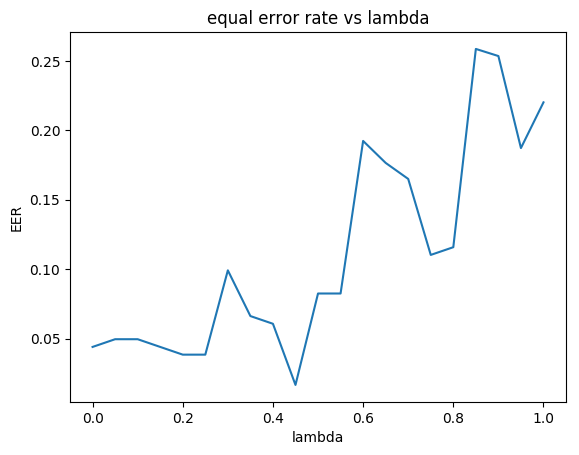

In [14]:
f = figure()
plot(lvec, eervec)
title("equal error rate vs lambda")
xlabel("lambda")
ylabel("EER")
show()